### Imports

In [1]:
import FilePathsBase
using FilePathsBase: /
import CSV
import DataFrames
import PlotlyJS

### Definitions, Constants, Paths

In [2]:
fuel_in_focus = "Power";

PlotInformation = @NamedTuple{plot_title::String, result_path::FilePathsBase.SystemPath}
plot_infos = PlotInformation.([(plot_title="Power Production per Technology for daystep 15 and hourstep 1", 
                                result_path=(FilePathsBase.@__PATH__) / "TestData" / "Results15_1" / "ProductionByTechnologyAnnual_minimal_MinimalExample_globalLimit_DE_run.csv")
                               (plot_title="Power Production per Technology for daystep 60 and hourstep 1", 
                                result_path=(FilePathsBase.@__PATH__) / "TestData" / "Results60_1" / "ProductionByTechnologyAnnual_minimal_MinimalExample_globalLimit_DE_run.csv")]);

infeasability_technologies::Vector{String} = ["Infeasibility_Power", "Infeasibility_HLI", "Infeasibility_HMI",
                                              "Infeasibility_HHI", "Infeasibility_HRI", "Infeasibility_Mob_Passenger",
                                              "Infeasibility_Mob_Freight"];

### Read, Filter, and Process data

In [3]:
# Read data
production_by_tech_data::Vector{DataFrames.DataFrame} = [CSV.read(p_info.result_path, DataFrames.DataFrame) for p_info in plot_infos];

# Filter techs by Power as fuel
production_by_tech_data::Vector{DataFrames.DataFrame} = [df[df.x3 .== fuel_in_focus, :] for df in production_by_tech_data];

# Remove 0 values
production_by_tech_data::Vector{DataFrames.DataFrame} = [df[df.y .!= 0, :] for df in production_by_tech_data];

# Group by, year and tech, then sum
production_by_tech_data::Vector{DataFrames.DataFrame} = [DataFrames.combine(DataFrames.groupby(df, [:x1, :x2]), :y => sum) for df in production_by_tech_data];

### Plot power productions

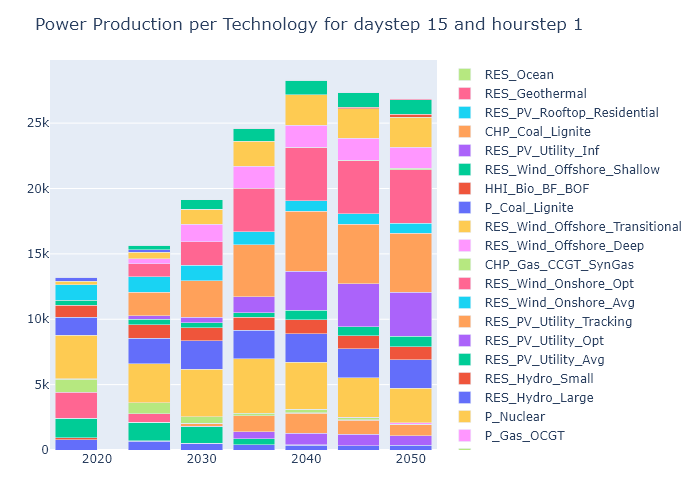

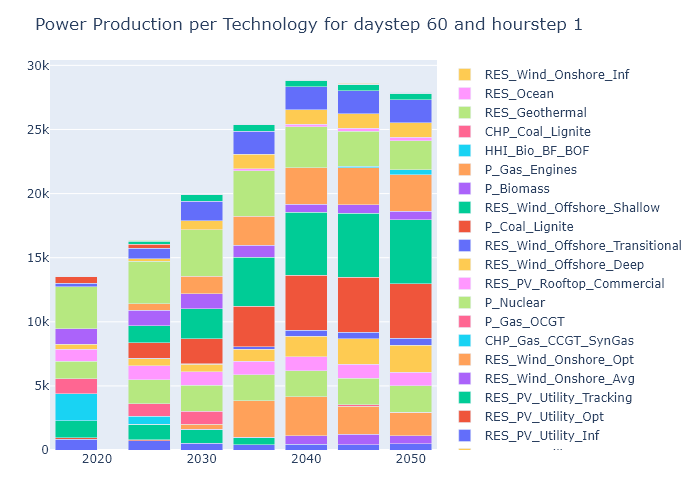

In [4]:
function generate_power_production_by_tech_plot_trace(production_by_tech::DataFrames.DataFrame; x_columns_symbol::Symbol=:x1, tech_column_symbol::Symbol=:x2, y_column_symbol::Symbol=:y_sum) :: Vector{PlotlyJS.GenericTrace}
    traces = []
    for tech in unique(production_by_tech[!, tech_column_symbol])
        tech_data = production_by_tech[production_by_tech[!, tech_column_symbol] .== tech, :]
        trace = PlotlyJS.bar(x=tech_data[!, x_columns_symbol], y=tech_data[!, y_column_symbol], name=tech)
        push!(traces, trace)
    end
    return traces  
end

function generate_plot_power_production_by_tech(plot_info::PlotInformation, production_by_tech::DataFrames.DataFrame; x_columns_symbol::Symbol=:x1, tech_column_symbol::Symbol=:x2, y_column_symbol::Symbol=:y_sum)
    traces = generate_power_production_by_tech_plot_trace(production_by_tech; x_columns_symbol=x_columns_symbol, tech_column_symbol=tech_column_symbol, y_column_symbol=y_column_symbol)
    layout = PlotlyJS.Layout(title=plot_info.plot_title, barmode="stack", height=800, width=1000)
    plot = PlotlyJS.plot(traces, layout)
    return plot
end

for (plot_info, data) in zip(plot_infos, production_by_tech_data)
    plot = generate_plot_power_production_by_tech(plot_info, data)
    display(plot)
end

### Plot overall Infeasibility tech activity for controlling

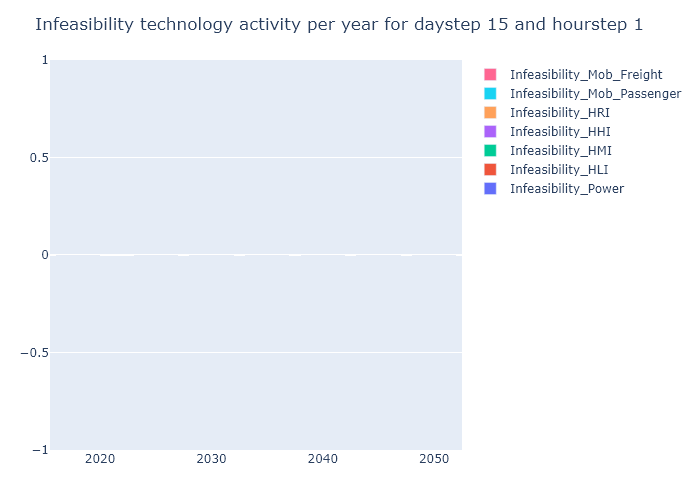

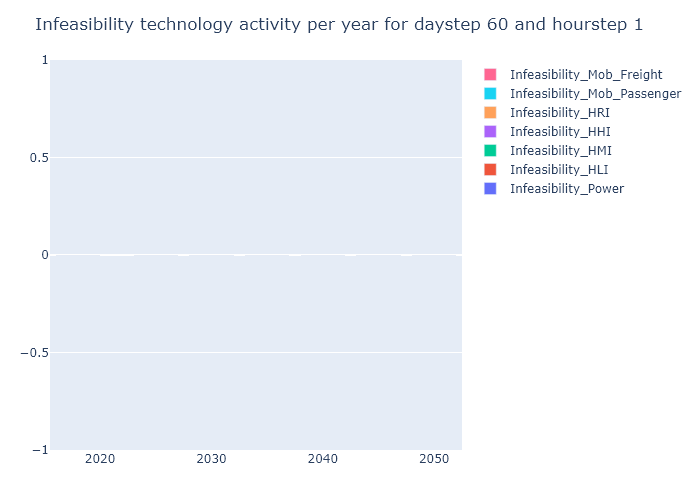

In [5]:
infeasibility_plot_infos = PlotInformation.([(plot_title="Infeasibility technology activity per year for daystep 15 and hourstep 1",
                                             result_path=(FilePathsBase.@__PATH__) / "TestData" / "Results15_1" / "TotalActivityPerYear_minimal_MinimalExample_globalLimit_DE_run.csv")
                                             (plot_title="Infeasibility technology activity per year for daystep 60 and hourstep 1",
                                             result_path=(FilePathsBase.@__PATH__) / "TestData" / "Results60_1" / "TotalActivityPerYear_minimal_MinimalExample_globalLimit_DE_run.csv")]);

# Read in data
infeasibility_data::Vector{DataFrames.DataFrame} = [CSV.read(p_info.result_path, DataFrames.DataFrame) for p_info in infeasibility_plot_infos];

# Filter infeasibility technologies
infeasibility_data::Vector{DataFrames.DataFrame} = [df[in.(df[!, :x3], Ref(infeasability_technologies)), :] for df in infeasibility_data];

# Sum over regions (combine regions when year and tech is same)
infeasibility_data::Vector{DataFrames.DataFrame} = [DataFrames.combine(DataFrames.groupby(df, [:x3, :x4]), :y => sum) for df in infeasibility_data];

# Make plots
for (plot_info, data) in zip(infeasibility_plot_infos, infeasibility_data)
    plot = generate_plot_power_production_by_tech(plot_info, data; x_columns_symbol=:x4, tech_column_symbol=:x3, y_column_symbol=:y_sum)
    display(plot)
end